##### AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Programu Operacyjnego Polska Cyfrowa na lata 2014-2020
<hr>

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<center>
    <h1 style = "font-size:48px; font-weight:normal"><b>AI</b>-TECH</style></h1>
    <br>
<br>
<br>
<br>
    <h1 style = "font-size:24px; font-weight:normal">Przykład 2 DO LABORATORIUM 3</style></h1>
    <h1 style = "font-size:24px">z UCZENIA MASZYNOWEGO</style></h1>
    <h1 style = "font-size:24px">Klasyfikacja nienadzorowana</style></h1>
    <h1 style = "font-size:24px">Adam Kurowski</style></h1>
    <h3 style = "font-size:21px">Dobór liczby klas w algorytmie k średnich i klasteryzacji hierarchicznej</h3>
    <h3 style = 
</center>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
    </body>
    </html>

![stopka.svg](stopka.svg)

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

<hr>

# Przykład 2.: Dobór liczby klastrów w algorytmie k średnich i klasteryzacji hierarchicznej


## Analiza struktury danych wejściowych

W tym przykładzie zajmiemy się już zagadnieniem nienadzorowanej klasyfikacji wysokowymiarowych zbiorów danych. Procesu tego już nie będzie dało się przedstawić w prosty sposób za pomocą obszarów decyzyjnych na dwuwymiarowej płaszczyźnie. Nadal jednak możliwe będzie zapoznanie się z efektami działania wybranych algorytmów (k średnich i hierarchicznego) za pomocą wizualizacji już bez pokazania granic obszarów przypisanych do poszczególnych klastrów. Granice te teraz będą już odnajdowane w przestrzeni wysokowymiarowej. 

In [35]:
# Import bibliotek
import numpy  as np # obliczenia numeryczne
import pandas as pd # przetwarzanie danych "tabelarycznych"
import matplotlib.pyplot as plt # wizualizacja danych
from sklearn.datasets import load_diabetes, load_boston # zbiory danych
from sklearn.decomposition import PCA # redukcja wymiarowości
from sklearn.cluster import KMeans, AgglomerativeClustering # implementacja algorytmu k średnich 
                                                            # i klasteryzacji hierarchicznej
import scipy.cluster.hierarchy as sch # procedury potrzebne do wizualizacji działania algorytmów hierarchicznych
import copy as cp # do wykonywania kopii struktur w przypadku, gdy nie chcemy zmodyfikować oryginalnych danych

Do dyspozycji w trakcie ćwiczenia będziemy posiadać zbiory danych danych [Boston Housing](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) i [Diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html), które także możemy łatwo pozyskać go za pomocą API udostępnianego przez bibliotekę scikit-learn, w której [dokumentacji](https://scikit-learn.org/stable/datasets/toy_dataset.html) przedstawione zostały także dodatkowe informacje na ich temat. Tym razem nie bądą to już zbiory przewidziane do ilustracji zadań klasyfikacji, tylko zbiory przeznaczone do testowania algorytmów regresji.
Może się to wydawać nieintuicyjne, bo przecież testować będziemy algorytmy klasyfikacji nienadzorowanej, jednak taki dobór danych pozwala na pokazanie jednego z praktycznych zastosowań klasyfikacji nienadzorowanej. W przykładzie zademonstrowany zostanie przykład poszukiwania klas danych, które wyróżniają się pod względem metryki typowo estymowanej w zadaniach regresji. <bre/>
Dla każdego ze zbiorów poszukamy klasy elementów (mieszkań, lub zestawów danych opisujących pacjentów) wskazujących na pewne szczególne klasy:
<ul>
    <li/> w zbiorze <b>Boston Housing</b> poszukamy klasy mieszkań, które są szczególnie wartościowe na tle innych nieruchomości, o których dane znajdują się w zbiorze,
    <li/> w zbiorze <b>Diabetes</b> poszukamy osób, których dane medyczne wskazują na to, że są zagrożone szczególnie szybkimi postępami choroby.
</ul>
    
<i> W ramach obowiązkowej części ćwiczenia skupimy się na zbiorze Boston Housing. Chętni studenci są jednak zachęcani do wypróbowania nowo pozyskanej wiedzy na dodatkowym zbiorze, jakim jest Diabetes, jeżeli uda im się szybko wykonać pozostałe zadania laboratoryjne.<i/>

In [36]:
# Załadowanie wybranego zbioru danych
dataset_dict = load_boston()
# dataset_dict = load_diabetes()

# Wypisanie podstawowych informacji o danych pozyskanych poprzez API biblioteki scikit-learn.
print('Słownik przechowujący zbiór danych ma następujące klucze:')
print(list(dataset_dict.keys()))

print()
print('Do dyspozycji są następujące cechy:')
print(dataset_dict['feature_names'])

# Kilka kluczy ze słownika dla wygody wydzielimy do zmiennych:
data          = dataset_dict['data']
target        = dataset_dict['target']


Słownik przechowujący zbiór danych ma następujące klucze:
['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module']

Do dyspozycji są następujące cechy:
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

W tym przykładzie także będziemy badać wpływ normalizacji. Odpowiedni kod jest zamieszczony w komórce poniżej.
<br/>
Na początku nie będziemy stosować normalizacji. Jej wpływ będzie badany w dalszej części ćwiczenia.

In [37]:
# normalizacja do zakresu od -1 do 1
def norm_unit_absval(data):
    data_norm = cp.copy(data)
    for i in range(data_norm.shape[1]):
        data_norm[:,i] = data_norm[:,i]-np.min(data_norm[:,i])
        data_norm[:,i] = data_norm[:,i]/np.max(data_norm[:,i])
        data_norm[:,i] = data_norm[:,i]*2 - 1
    return data_norm

# standaryzacja
def norm_standardize(data):
    data_norm = cp.copy(data)
    for i in range(data_norm.shape[1]):
        data_norm[:,i] = data_norm[:,i]-np.mean(data_norm[:,i])
        data_norm[:,i] = data_norm[:,i]/np.std(data_norm[:,i])
    return data_norm

# Odkomentować, jeżeli normalizacja jest potrzebna:
data_norm = cp.copy(data) # Odkomentować jeśli nie korzystamy z normalizacji
# data_norm = norm_unit_absval(data)
# data_norm = norm_standardize(data)

W przykładzie 2. do wizualizacji posłużymy się tylko algorytmami redukcji wymiarowości za pomocą PCA. Punkty uzyskane w ten sposób zostaną oznaczone kolorem w zależności od wartości metryki stanowiącej daną wejściową lub daną przybliżaną, która w przypadku pokazywanym w tym przykładzie będzie służyć do wyłonienia wyróżniających się klas danych. Ich współrzędne policzone są w komórce poniżej:

In [38]:
# Obiekt algorytmu redukcji wymiarowości do 2 wymiarów.
pca = PCA(n_components=2)

# Efekt redukcji wymiarowości zapiszemy w osobnej zmiennej:
reduced_data = pca.fit_transform(data_norm)

Wizualizacja przetwarzanego zbioru danych może być zrealizowana za pomocą kodu podanego w komórce poniżej. Warto też zapoznać się z rozkładem wartości przechowywanych w poszczególnych wymiarach zbioru danych. Rozkład ten zwizualizowany jest za pomocą mapy koloru.

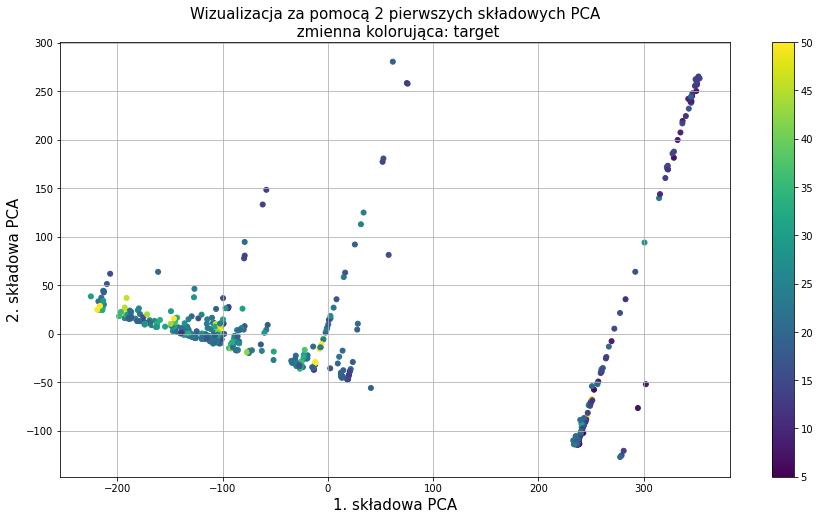

In [40]:
# W zmiennej coloring_variable_name można wybrać zmienną, która wykorzystana będzie do kolorowania
# punktów na zobrazowaniu wykorzystującym PCA, jest to przydatne by zorientować się, jaki wpływ na umiejscowienie
# punktów mają poszczególne wymiary zbioru danych. Poniżej podane są nazwy poszczególnych wymiarów:
# 
# - w zbiorze Boston Housing do dyspozycji są następujące wymiary:
# 'CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT'
# 
# - w zbiorze Diabetes do dyspozycji są z kolei zmienne:
# 'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'

# Jeśli wybrana ma być zmienna stanowiąca pierwotnie cel regresji w zbiorach danych, to należy zmiennej coloring_variable_name
# nadać wartość 'target'. 
#
#     W zbiorze Boston Housing będzie to oznaczać medianę ceny nieruchomości w obszarze, 
#     którego dotyczy punkt, wyrażoną w tysiącach dolarów.
#
#    W zbiorze Diabetes, zmienna target oznaczać będzie ilościową metrykę informującą o postępie choroby - im większa
#    jej wartość, tym większy postęp choroby w rok po dokonaniu pomiaru pozostałych wartości w zbiorze danych.

coloring_variable_name = 'target'

# Sprawdzamy, czy mamy wybrać zmienną target, czy kolumnę w tablicy data_norm.
if coloring_variable_name == 'target':
    coloring_variable = target
else:
    dim_index         = np.where(dataset_dict['feature_names'] == coloring_variable_name)
    coloring_variable = data_norm[:,dim_index].squeeze()

# Zdefiniowanie rozmiarów wykresu
plt.figure(figsize=(15,8))

# Opisujemy osie
plt.xlabel('1. składowa PCA', fontsize=15)
plt.ylabel('2. składowa PCA', fontsize=15)
plt.scatter(reduced_data[:,0],reduced_data[:,1], c=coloring_variable, s=25)

# Na koniec dodajemy tytuł, legendę i rysujemy siatkę.
plt.colorbar()
plt.title(f'Wizualizacja za pomocą 2 pierwszych składowych PCA\n zmienna kolorująca: {coloring_variable_name}', fontsize=15)
plt.grid()

# W razie potrzeby można pomniejszyć lub zmienić wizualizowany fragment za pomocą funkcji xlim i ylim.
# plt.xlim([-2.5,2.5])
# plt.ylim([-2.5,2.5])

Separacja międzyklasowa w zbiorze wine ma tę cechę, że zawsze znajdziemy klaster, który blisko sąsiaduje z innym klastrem. Zobaczymy, jak poradzą sobie z tym faktem algorytmy klasyfikacji nienadzorowanej.

## Algorytm k średnich
<p>Do znalezienia grup punktów danych, wyróżniających się na tle wybranej metryki docelowej posłużymy się najpierw algorytmem k średnich. Tu jednak pojawia się pierwszy problem. Konieczna jest decyzja odnośnie dokładnej wartości parametru $k$. Z pomocą może przyjść tu prosta metoda polegająca na obliczaniu średniego dystansu pomiędzy punktami w klastrach generowanych przez algorytm k średnich. Jest to metoda poszukiwania punktu przegięcia funkcji, która wiąże liczbę klastrów $k$ z średnim dystancem pomiędzy punktami w klastrze (ang. *elbow method*). Wymaga ona obliczenia algorytmu k średnich wiele razy i wykreślenia odpowiedzniego wykresu. Na szczęście biblioteka scikit-learn umożliwia pobranie metryki będącej sumą podniesionych do kwadratu dystansów między punktami. Jest to parametr o angielskiej nazwie *intertia*, który dalej dla wygody będziemy dalej nazywać inercją.</p>

<p>Punkt przegięcia wykresu tej wartości pomoże w wyborze odpowiedniej liczby klastrów. Funkcja ta jest zawsze malejąca bo wraz ze wzrostem liczby klastrów dystanse między punktami zawsze maleją. Punkt przegięcia jednak wyznacza tę liczbę klastrów, dla której ten spadek przestaje być gwałtowny. Zakładamy, że dzieje się tak dlatego, że właśnie w tym punkcie znaleźliśmy wartość $k$ najlepiej dopasowaną do wewnętrznej struktury analizowanych przez nas danych.</p>

Text(0, 0.5, 'druga pochodna inercji')

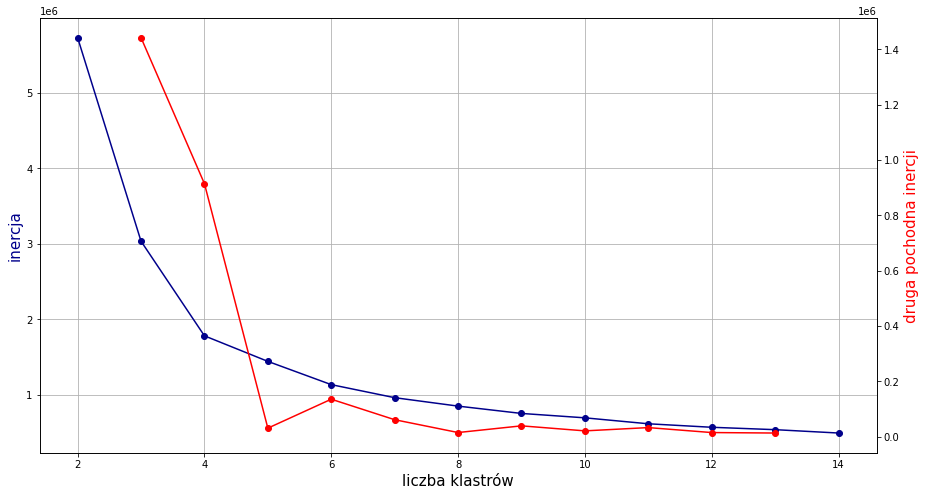

In [41]:
# Listy w których będziemy zapisywać poszczególne wartości parametru k i odpowiadających im wartości 
# metryki uśredninej odległości pomiędzy punktami.
k_values            = []
intertia_scores_vec = []

# Następnie w pętli wywołujemy algorytm k średnich i zapisujemy wartości k oraz intercji.
# Tym razem wykorzystamy domyślne nastawy pracy algorytmu przyjęte w bibliotece scikit-learn.
for k in range(2,15):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(data_norm)
    intertia_scores_vec.append(clusterer.inertia_)
    k_values.append(k)

# Na koniec rysujemy wykres inercji w funkcji liczby klastrów k.
fig = plt.figure(figsize=(15,8))
plt.plot(k_values,intertia_scores_vec, marker='o', c='darkblue')
plt.grid()
# Na dodatkowej (prawej) osi y narysujemy drugą pochodną funkcji inercji, co pozwoli łatwiej odnaleźć punkt 
# gdzie dynamika zmian inercji (przyspieszenie) jest możliwie mała. W najlepszym przypadku - będzie to minimum
# modułu drugiej pochodnej.
ax1 = plt.gca()
ax2 = ax1.twinx()
module_of_second_derivative = np.abs(np.diff(np.diff(intertia_scores_vec)))
ax2.plot(k_values[1:-1], module_of_second_derivative, marker='o',color='red')

# Opis osi
ax1.set_xlabel('liczba klastrów', fontsize=15)
ax1.set_ylabel('inercja', color='darkblue', fontsize=15)
ax2.set_ylabel('druga pochodna inercji',color='red', fontsize=15)

Przy domyślnych ustawieniach analizy w przykładzie - pierwsze minimum modułu drugiej pochodnej inercji występuje dla wartości $k=5$, co sugeruje, że to właśnie dla tej liczby klastrów warto wykonać pierwszą analizę. Należy pamiętać, że niestety w ogólności nie istnieje gwarancja, że tego typu minimum będzie istnieć. Stąd dla bardzo trudnych przypadków dobór liczby klastrów nawet na podstawie wykresu intercji jest uznaniowy.

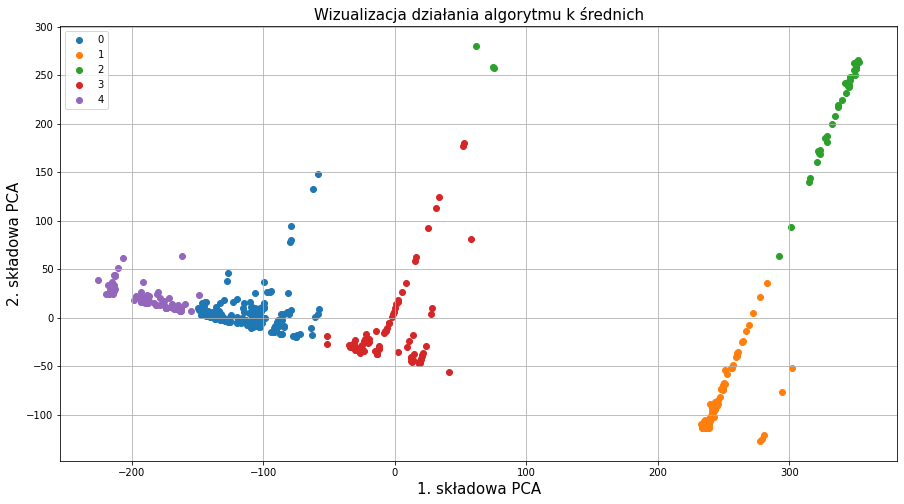

In [42]:
# Liczba klastrów, której się spodziewamy na podstawie wykresu inercji.
n_clusters = 5

# Wykonanie algorytmu k średnich
clusterer = KMeans(n_clusters=n_clusters)
clusterer.fit(data_norm)
k_means_predictions = clusterer.predict(data_norm)

# Wizualizacja poprzez oznaczenie klastrów kolorami na efekcie algorytmu PCA.
plt.figure(figsize=(15,8))
# Narysujemy wykres punktowy z rozdzieleniem danych na klasy.
for val in np.unique(k_means_predictions):
    # Generujemy sobie maskę za pomocą której wybierzemy punkty należące do każdej z klas.
    mask = k_means_predictions==val
    # Dla tak wszystkich punktów wybranych za pomocą odpowiadającej danej klasie maski rysujemy wykres punktowy.
    plt.scatter(reduced_data[mask,0],reduced_data[mask,1], label=val)

# Oznaczenie osi i dodatkowe elementy wykresu.
plt.xlabel('1. składowa PCA', fontsize=15)
plt.ylabel('2. składowa PCA', fontsize=15)
plt.title("Wizualizacja działania algorytmu k średnich", fontsize=15)
plt.grid()
plt.legend(fontsize=10)

Zadaniem w ramach przykładu jest odszukanie takich skupisk punktów danych, które istotnie odróżniają się od innych skupisk, jeżeli porównać powiązane z nimi wartości metryki docelowej. Aby móc sprawdzić te wartości posłużymy się wykresem pudełkowym. Pozwala on na łatwie graficzne zwizualizowanie podstawowych statystyk dotyczących każdego klastra, dokładniejszy opis objaśniający w jaki sposób należy interpretować wykres pudełkowy można odnaleźć na przykład w [dokumentacji biblioteki Pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html). 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 1.0, 'rozkład wartości wybranej wielkości w zależności od klasy, wybrana wielkość: NOX')

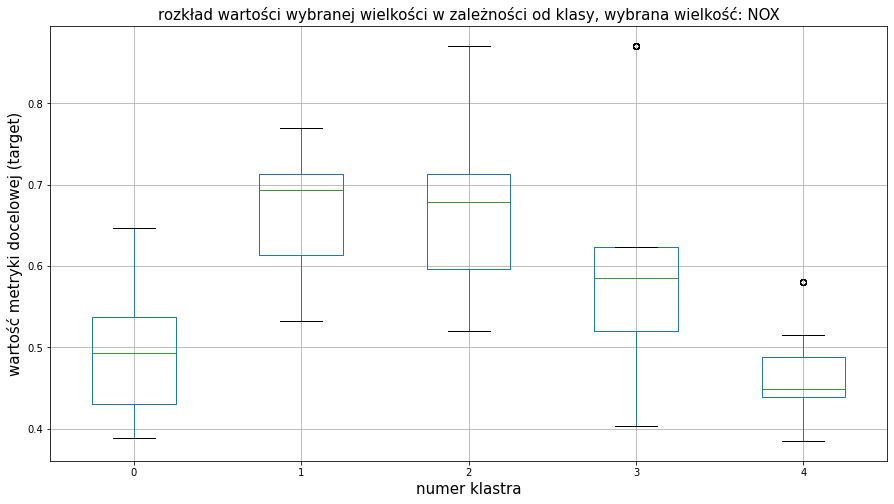

In [48]:
# W wizualizacji cech klastrów znowu będzie możliwy wybór wizualizowanej wielkości - zmienna docelowa to wartość 'target',
# wymiar pochodzący ze zbioru danych natomiast, to odpowiednia nazwa wymiaru:
# 
# - w zbiorze Boston Housing do dyspozycji są następujące wymiary:
# 'CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT'
# 
# - w zbiorze Diabetes do dyspozycji są z kolei zmienne:
# 'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'

# Nazwa wizualizowanej wielkości:
visualized_quantity_name = 'target'

# Sprawdzamy, czy mamy wybrać zmienną target, czy kolumnę w tablicy data_norm.
if visualized_quantity_name == 'target':
    visualized_quantity = target
else:
    dim_index           = np.where(dataset_dict['feature_names'] == visualized_quantity_name)
    visualized_quantity = data_norm[:,dim_index].squeeze()

# Proces wizualizacji aczniemy od pustej listy.
clusterized_income_df = []

# W pętli dodajemy do listy wartości metryki docelowej (target), z której za pomocą maski
# wybieramy wartości powiązane z każdym z klastrów.
for val in np.unique(k_means_predictions):
    mask = k_means_predictions==val
    clusterized_income_df.append(visualized_quantity[mask])

# Na koniec konwertujemy listę do ramki danych (DataFrame)
clusterized_income_df = pd.DataFrame(clusterized_income_df).T

# Na podstawie tak przygotowanej ramki danych można w prosty sposób przygotować wykres pudełkowy za pomocą
# metody .boxplot().
plt.figure(figsize=(15,8))
clusterized_income_df.boxplot()
plt.xlabel('numer klastra', fontsize=15)
plt.ylabel('wartość metryki docelowej (target)', fontsize=15)
plt.title(f'rozkład wartości wybranej wielkości w zależności od klasy, wybrana wielkość: {visualized_quantity_name}', 
          fontsize=15)

Przy domyślnych nastawach analizy w przykładzie - jesteśmy w stanie zaobserwować, że udało się odszukać skupisko (klasę, klaster) nieruchomości szczególnie wartościowych, jak i klasy, które powiązane są z tymi o najmniejszej wartości (np. klasa nr 3). 

## Algorytm hierarchiczny
<p>Algorytm k średnich nie jest jedynym możliwym sposobem nienadzorowanej klasyfikacji danych. Tzw. podejście hierarchiczne jest innym przykładem metody, w której punkty łączone są w skupienia w sposób niewymagający definiowania klas danych. Łączenie to odbywa się poprzez dobór takich punktów (a później - skupisk punktów), których połączenie w większe grupy powoduje najmniejszy możliwy wzrost metryki opisującej sposób podziału danych na klasy. W bibliotece scikit-learn algorytm taki zaimplementowany jest w postaci obiektu [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Łączenie punktów w skupiska może opierać się na minimalizacji przyrostu czterech możliwych metryk:</p>
<ul>
    <li/> <b>metryki Warda</b>, której użycie minimalizuje wariancję tworzonych klastrów,
    <li/> <b>średniego dystansu</b> pomiędzy punktami znajdującymi się w różnych klastrach,
    <li/> <b>maksymalnej odległości</b> pomiędzy dwoma punktami znajdującymi się w różnych klastrach,
    <li/> <b>minimalnej odległości</b> pomiędzy dwoma punktami znajdującymi się w różnych klastrach.
</ul>

<p>Przebieg procesu łączenia pojedynczych punktów w klastry można prześledzić za pomocą tzw *dendrogramu*. Jest to rodzaj wizualizacji, który pokazuje jak zachowuje się wartość wybranej metryki wraz z łączeniem ze sobą kolejnych skupisk danych. Na dole dendrogramu znajdują się pojedyncze punkty danych, na jego górze znajduje się część odpowiadająca wartości metryki dla podziału danych na dwa skupiska (klasy).</p> 
<p>Dendrogram można wykorzystać do określenia liczby klas na które można podzielić klasyfikowane w sposób nienadzorowany dane. Zależy nam na wybraniu takiej liczby klastrów, dla której podział na mniejszą lub większą liczbę klastrów powoduje znaczną, największą możliwą zmianę metryki. Podział taki charakteryzowany jest przez ten obszar dendrogramu, dla którego widoczne są tylko pionowe kreski oznaczające poszczególne klastry (kreski poziome oznaczają podziału). Jest to tożsame z powiedzeniem, że jest to taka liczba klastrów, dla których odległość pomiędzy poziomymi markerami podziałów jest największa. Przykładowy dendrogram dla danych przetwarzanych w tym przykładzie jest widoczny poniżej:

Text(0.5, 1.0, 'dendrogram algorytmu hierarchicznego dla metryki: average')

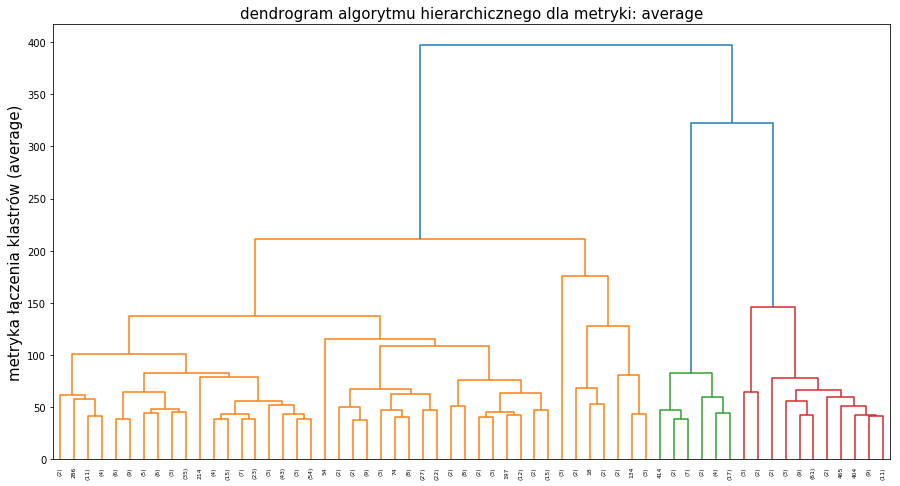

In [ ]:
# Dostępne metryki łączenia klastrów:
#    'ward'     - metryka minimalizująca wariancję łączonych klastrów
#    'average'  - maksymalizuje średni dystans pomiędzy punktami 
#                 w różnych klastrach
#    'complete' - minimalizuje maksymalną odległość 
#                 między punktami w klastrach
#    'single'   - maksymalizuje najmniejszą odległość
#                 między punktami w klastrach

# Wybieramy metrykę według której łączymy poszczególne punkty danych
linkage_method = 'average'

# Rysujemy dendrogram
plt.figure(figsize=(15,8))
dend = sch.dendrogram(sch.linkage(data_norm, method=linkage_method), truncate_mode='lastp', p=60)
plt.ylabel(f'metryka łączenia klastrów ({linkage_method})',fontsize=15)
plt.title(f'dendrogram algorytmu hierarchicznego dla metryki: {linkage_method}',fontsize=15)

# Odczytywanie informacji o liczbie klastrów może nie być na początku intuicyjne. Dendrogram to schemat pokazujący wzrost
# wybranej metryki (u nas podawanej w zmiennej linkage_method) wraz z łączeniem mniejszych grup punktów w coraz większe
# klastry. Punkty łączenia symbolizowane są przez poziome kreski. Naszym zadaniem jest znaleźć takie łączenia 
# (poziome kreski), pomiędzy którymi jest największy odstęp - oznacza to, że jest to najbardziej "kosztowne" połączenie
# w historii działań wykonywanych przez algorytm. 
# Pionowe kreski odpowiadają poszczególnym klastrom istniejącym w danej chwili, dlatego po wyznaczeniu tego 
# najbardziej kosztownego łączenia wystarczy policzyć, ile klastrów (symbolizowanych przez pionowe kreski)
# jest obecnych w stanie przed tym najbardziej kosztownym połączeniem
#
# Przykładowo, dla domyślnych nastaw skryptów, możemy taki obszar od łączenia najbardziej kosztownego (wyżej 
# umiejscowionego na dendrogramie) do jego poprzednika (położonego niżej na dendrogramie).:

# (domyślnie linijki są zakomentowane, by pokazać jak wygląda dendrogram, odkomentuj aby zobaczyć sposób doboru
# wartości k na podstawie dendrogramu)
# plt.gca().axhline(211, c='k') # "dolny" sąsiad najbardziej kosztownego połączenia
# plt.gca().axhline(323, c='k') # najbardziej kosztowne połączenie klastrów
# plt.gca().axhline(260, c='k', linestyle='--') # najbardziej kosztowne połączenie klastrów
# plt.gca().text(10, 270, 'linia przerywana przecina 3 pionowe kreski, optymalne k to 3') # najbardziej kosztowne połączenie klastrów

# pomiędzy łączeniami mamy 3 kreski oznaczające, że przed wykonaniem najbardziej kosztownego (niekorzystnego) łączenia 
# istnieją 3 klastry i taka właśnie jest optymalna liczba klastrów odczytana z dendrogramu.

Na powyższym dendrogramie, dla domyślnych danych, widoczny jest szczególnie długi obszar bez podziałów klastrów występujący dla 3 klastrów (długość mierzymy od najwyższej pomarańczowej poziomej linii do najniższej poziomej linii niebieskiej). Stąd w kodzie poniżej dla domyślnych danych, dla metryki powiązanej ze średnim dystansem pomiędzy punktami przyjmiemy, że $k=3$.

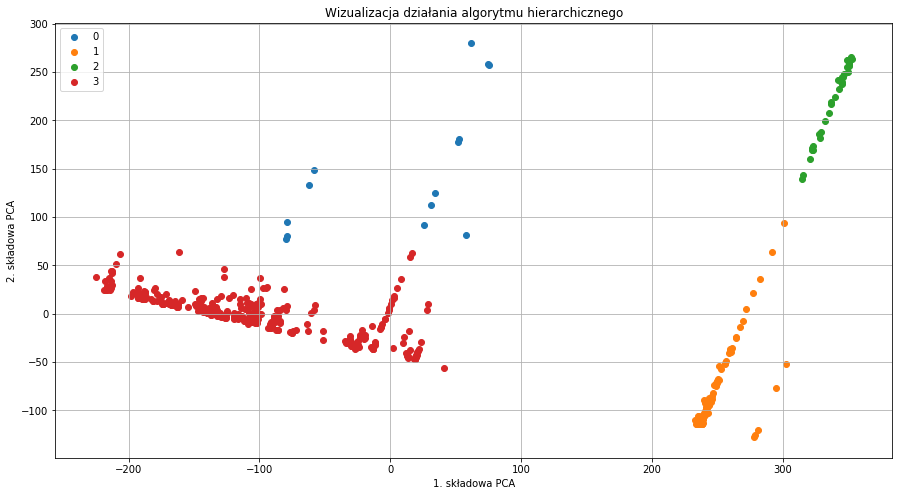

In [ ]:
# Liczba klastrów, której się spodziewamy na podstawie wyglądu dendrogramu.
n_clusters = 4

# Wykonanie algorytmu hierarchicznego:
clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
clusterer.fit(data_norm)

# Zapisujemy sobie wynik przypisania danych do klastrów.
agclust_predictions = clusterer.labels_

# Wizualizacja za pomocą wcześniej wprowadzonej już funkcji plot_decision_regions.
plt.figure(figsize=(15,8))
# Narysujemy wykres punktowy z rozdzieleniem danych na klasy.
for val in np.unique(agclust_predictions):
    # Generujemy maskę za pomocą której wybierzemy punkty należące do każdej z klas.
    mask = agclust_predictions==val
    # Dla tak wszystkich punktów wybranych za pomocą odpowiadającej danej klasie maski rysujemy wykres punktowy.
    plt.scatter(reduced_data[mask,0],reduced_data[mask,1], label=val)

# Oznaczenia osi i pozostałe elementy wykresu.
plt.xlabel('1. składowa PCA')
plt.ylabel('2. składowa PCA')
plt.title("Wizualizacja działania algorytmu hierarchicznego")
plt.grid()
plt.legend()

Dla domyślnych danych uzyskaliśmy nieco inny podział za pomocą algorytmu hierarchicznego (względem algorytmu k średnich). Spróbujmy zatem znowu narysować, jak w zależności od klastra wygląda wykres pudełkowy metryki docelowej. 

Text(0.5, 1.0, 'rozkład wartości wybranej wielkości w zależności od klasy, wybrana wielkość: target')

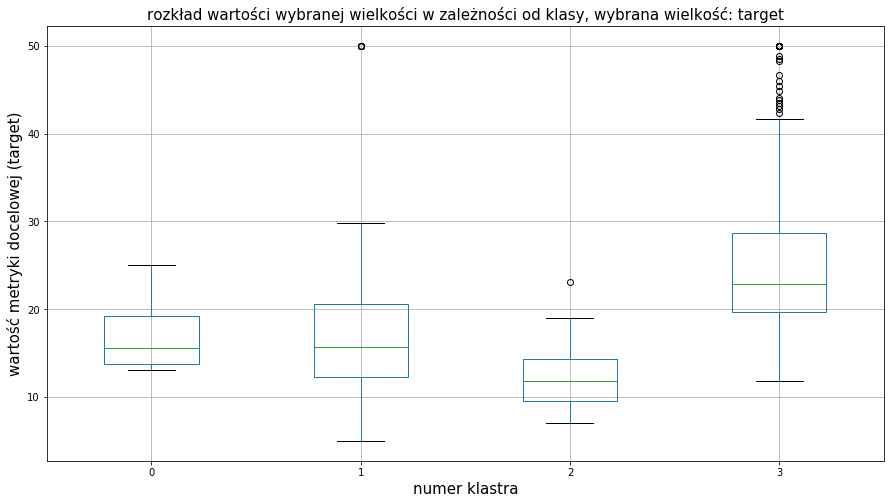

In [ ]:
# W wizualizacji cech klastrów znowu będzie możliwy wybór wizualizowanej wielkości - zmienna docelowa to wartość 'target',
# wymiar pochodzący ze zbioru danych natomiast, to odpowiednia nazwa wymiaru:
# 
# - w zbiorze Boston Housing do dyspozycji są następujące wymiary:
# 'CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO' 'B' 'LSTAT'
# 
# - w zbiorze Diabetes do dyspozycji są z kolei zmienne:
# 'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'

# Nazwa wizualizowanej wielkości:
visualized_quantity_name = 'target'

# Sprawdzamy, czy mamy wybrać zmienną target, czy kolumnę w tablicy data_norm.
if visualized_quantity_name == 'target':
    visualized_quantity = target
else:
    dim_index           = np.where(dataset_dict['feature_names'] == visualized_quantity_name)
    visualized_quantity = data_norm[:,dim_index].squeeze()

# Proces wizualizacji aczniemy od pustej listy.
clusterized_income_df = []

# W pętli dodajemy do listy wartości metryki docelowej (target), z której za pomocą maski
# wybieramy wartości powiązane z każdym z klastrów.
for val in np.unique(agclust_predictions):
    mask = agclust_predictions==val
    clusterized_income_df.append(visualized_quantity[mask])

# Na koniec konwertujemy listę do ramki danych (DataFrame)
clusterized_income_df = pd.DataFrame(clusterized_income_df).T

# Na podstawie tak przygotowanej ramki danych można w prosty sposób przygotować wykres pudełkowy za pomocą
# metody .boxplot().
plt.figure(figsize=(15,8))
clusterized_income_df.boxplot()
plt.xlabel('numer klastra', fontsize=15)
plt.ylabel('wartość metryki docelowej (target)', fontsize=15)
plt.title(f'rozkład wartości wybranej wielkości w zależności od klasy, wybrana wielkość: {visualized_quantity_name}', 
          fontsize=15)

W przypadku algorytmu hierarchicznego otrzymane klasy można wręcz zinterpretować jako klasę nieruchomości najdroższych (skupisko o indeksie 0), klasę nieruchomości o średniej cenie (1) i klasę nieruchomości o najniższej wartości (indeks 2.).

# Zadania do wykonania

<i><b>Przed przystąpieniem do wykonywania zadań pamiętaj zapoznać się z kodem demonstrującym odczyt prawidłowej wartości $k$ na podstawie dendrogramu.</b></i>

## Zadanie 1.
Zapoznaj się ze strukturą danych w zbiorze Boston Housing za pomocą wizualizacji na wykresie PCA (pierwsza wizualizacja od góry). 
<ol>
<li/>Zwróć uwagę, czy jesteś w stanie wizualnie wyróżnić odseparowane od siebie grupy punktów. 
<li/>Zmieniając wartość zmiennej <i>coloring_variable_name</i> znajdź przykład 2 zmiennych (<b>z wyjątkiem zmiennej target</b>), które mogły mieć wpływ na to, że dane grupy punktów są od siebie odseparowane na wizualizacji. Podaj ich nazwy i wizualizacje w sprawozdaniu. 
</ol>

## Zadanie 2.
Przejdź do sekcji przykładu zawierającej wykresy pudełkowe. Pozostawiając domyślny zbiór danych (Boston Housing) sprawdź za pomocą wykresów pudełkowych, jak kształtują się wartości poszczególnych kolumn zbioru danych w różnych grupach wygenerowanych przez algorytmy klasyfikacji nienadzorowanej. Czy jesteś w stanie na tej podstawie wywnioskować, jakie czynniki miały wpływ na takie a nie inne ceny mieszkań w poszczególnych klasach?
Podaj 2 przykłady zmiennych (**z wyjątkiem zmiennej target**), dla których można zaobserwować taką sytuację. Podaj ich nazwy i wykresy pudełkowe w sprawozdaniu. Wykonaj tę czynność zarówno dla algorytmu k średnich, jak i hierarchicznego.

## Zadanie 3.
Zbadaj zachowanie się algorytmu k średnich i hierarchicznego w zależności od sposobu normalizacji danych. Czy któryś ze sposobów normalizacji danych pozwolił na znalezienie klas, które jeszcze lepiej niż w zadaniu poprzednim wyróżniają się pod względem związanych z nimi cen mieszkań? (sprawdź to za pomocą wykresu pudełkowego) W trakcie badań może zmienić się optymalna liczba klas, dlatego w razie potrzeby należy ją zmienić za pomocą analizy wykresu intercji/dendrogramu.


##Zadanie1
###1)
Wizualnie można odróżnić 2 grupy punktów
###2)
INDUS


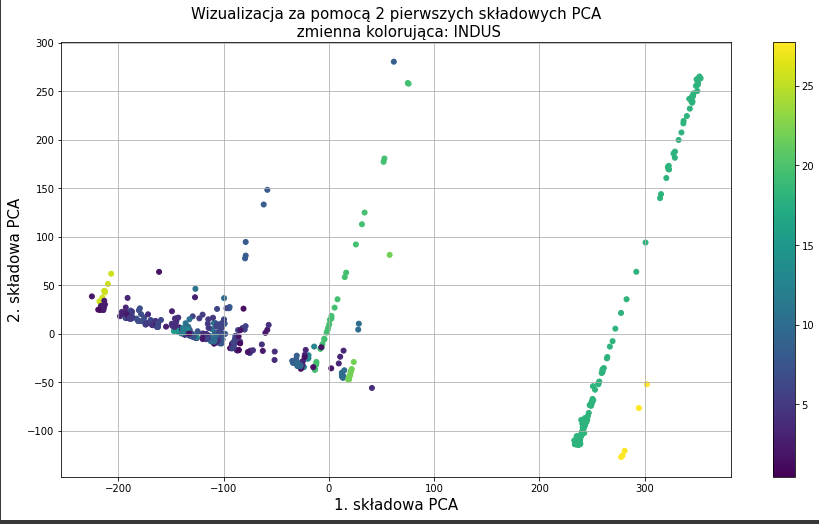


TAX

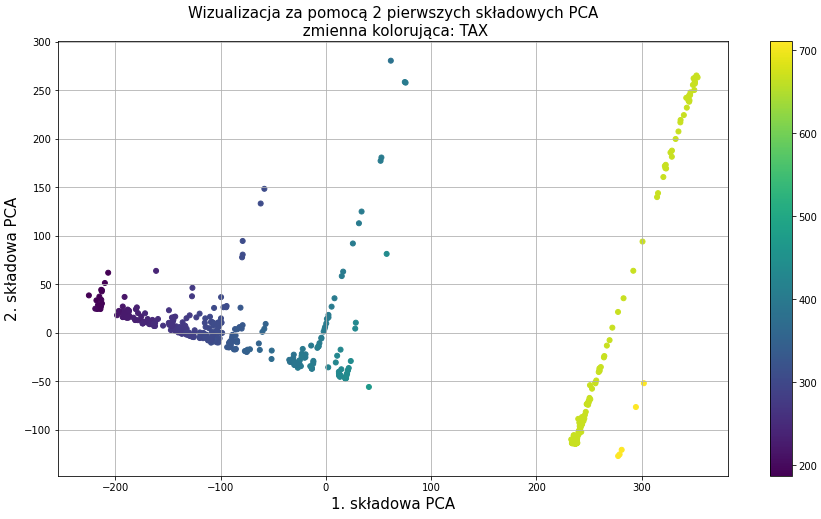

B

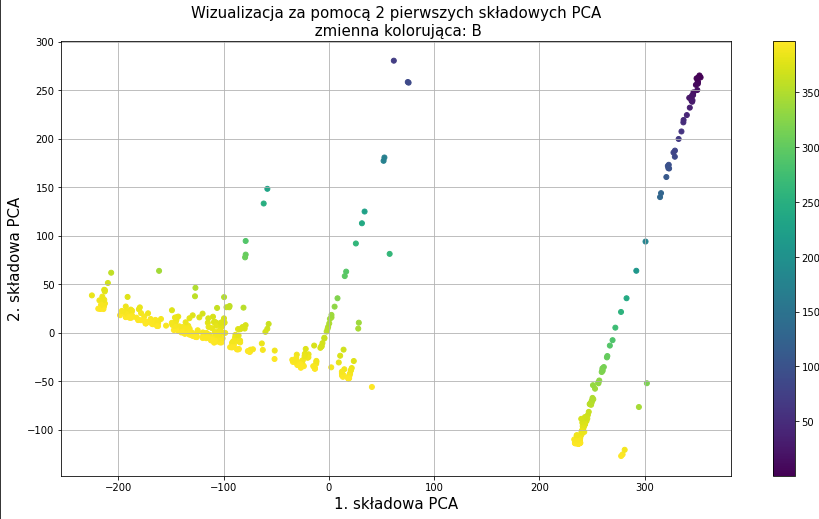

![stopka.svg](stopka.svg)